In [1]:
import os
import sys
sys.path.insert(0, "..")
import gc
gc.enable()

In [2]:
from utils.DataLoader import DataLoader
from utils.utilities import *
from utils.visualization import *
from models.unet import UNet
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)
dl = DataLoader()

Num GPUs Available:  1


In [3]:
train_df, valid_df = dl.train_split(0.2, filterNan=True)
print("train set shape", train_df.shape)
print("validation set shape", valid_df.shape)

train set shape (7632, 5)
validation set shape (1908, 5)


In [4]:
grouped_images_gen = dl.get_grouped_images_gen(train_df, f="adaptive_equalizer") # applying filters increases dramatically the execution time
aug_gen = get_augmented_images_generator(grouped_images_gen)
valid_x, valid_y = next(dl.get_grouped_images_gen(valid_df, batch_size=800, f="adaptive_equalization")) #valid_df.shape[0]))

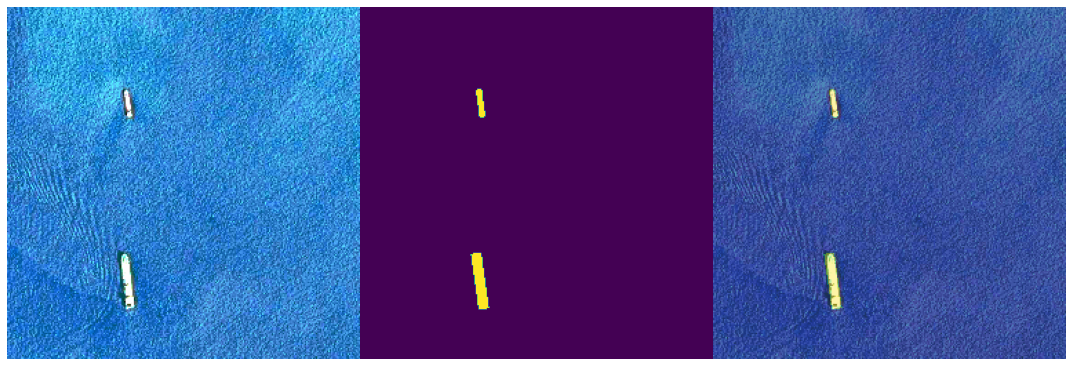

In [7]:
train_x, train_y = next(grouped_images_gen)
plot_masks(train_x[6], train_y[6])

In [8]:
t_x, t_y = next(aug_gen)
x_shape =np.squeeze(t_x[0]).shape

unet_model = UNet(x_shape, "../models/serialized/")
unet_model.compile()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 256, 256, 3)  0           batch_normalization[0][0]        
_____________

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Epoch 1/8
800/200 [========================================================================================================================] - 5s 6ms/sample - loss: -0.0074 - dice_coef: 0.0168 - binary_accuracy: 0.9302

Epoch 00001: val_loss improved from inf to -0.00857, saving model to ../models/serialized/unet_weights.best.hdf5
200/200 [==============================] - 64s 322ms/step - loss: -0.0074 - dice_coef: 0.0144 - binary_accuracy: 0.3745 - val_loss: -0.0086 - val_dice_coef: 0.0168 - val_binary_accuracy: 0.9302
Epoch 2/8
800/200 [========================================================================================================================] - 5s 6ms/sample - loss: -0.0010 

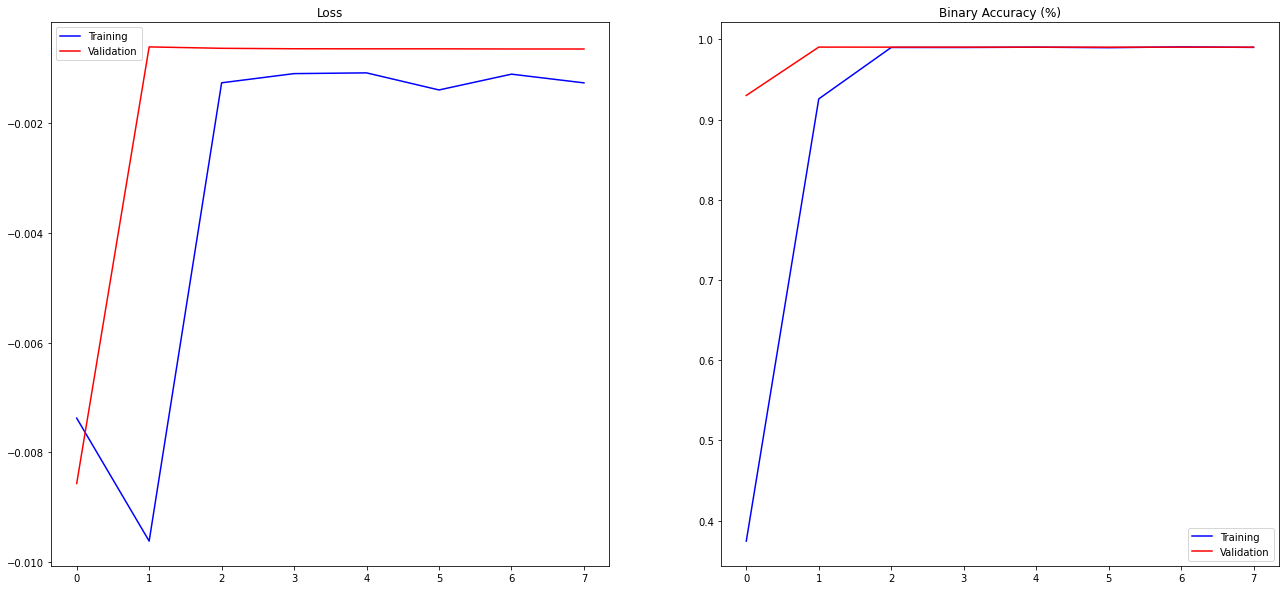

In [9]:
hl = unet_model.validate(aug_gen, train_df.shape[0], valid_set=(valid_x, valid_y), epochs=8)
unet_model.show_loss(hl)

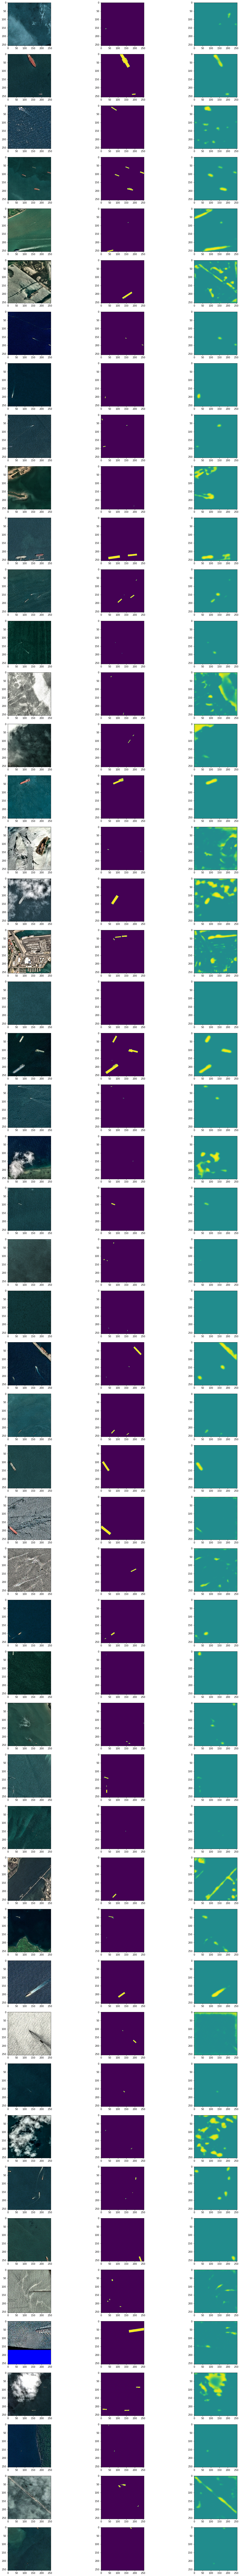

In [10]:
unet_model.visualize_validation(valid_x, valid_y, load=True)